In [74]:
!pip install pandas scikit-learn nltk
!pip install scikit-learn sentence_transformers pandas numpy
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.metrics import silhouette_score
import re
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import download
import numpy as np

cluster_df= pd.read_csv('cluster_df.csv')
def preprocess_sentence(sentence):
    # Ensure the input is a string
    sentence = str(sentence)

    # Convert the sentence to lowercase
    sentence = sentence.lower()

    # Remove punctuation
    sentence = re.sub(r'[^\w\s]', '', sentence)

    # Remove non-alphanumeric characters
    sentence = re.sub(r'[^a-zA-Z\s]', '', sentence)

    # Define stop words
    stop_words = set(stopwords.words('english'))

    # Initialize the lemmatizer
    lemmatizer = WordNetLemmatizer()

    # Add additional stop words
    additional_words = {'el', 'ge','la', 'de', 'br','mi','na','que','se','lo','en'}
    stop_words.update(additional_words)

    # Remove stop words and perform lemmatization
    sentence = ' '.join([lemmatizer.lemmatize(word) for word in sentence.split() if word not in stop_words])

    # Remove extra whitespace
    sentence = re.sub(r'\s+', ' ', sentence).strip()

    return sentence



cluster_df['text'] = cluster_df['text'].apply(preprocess_sentence)


cluster_df['text'].replace('', np.nan, inplace=True)

print(cluster_df)





[notice] A new release of pip is available: 24.1.2 -> 24.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.1.2 -> 24.2
[notice] To update, run: pip install --upgrade pip


[nltk_data] Downloading package stopwords to /Users/apple/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/apple/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


         Category                                               text
0       Cluster 1              part came quickly fit lg dryer thanks
1       Cluster 1  easy install fit exactly part replaced door st...
2       Cluster 1                            far good fit like glove
3       Cluster 1                                  job original part
4       Cluster 1                         look install like original
...           ...                                                ...
342696  Cluster 7  like factory filter easy install bargain compa...
342697  Cluster 7  worked great first time turned water filter do...
342698  Cluster 7  refrigerator water filter leaked installed rep...
342699  Cluster 7  awesome filter expensive go somewhere else pur...
342700  Cluster 7  one best filter ever usedi searching ultra fin...

[342701 rows x 2 columns]


In [77]:
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation

review_data = cluster_df['text'].astype(str)
labels = cluster_df['Category'].apply(lambda x: int(re.search(r'\d+', x).group()) - 1)

k = 7
# Assign data to each cluster
clustered_sentences = [[] for i in range(k)]
for sentence, cluster_id in zip(review_data, labels):
    clustered_sentences[cluster_id].append(sentence)

# Dictionary to store topics for all clusters
cluster_topics_dict = {}

# List to store doc_topic for each cluster
doc_topic_per_cluster = []

# Apply TF-IDF and LDA to each cluster
for i, sentences in enumerate(clustered_sentences):
    print(f"\nCluster {i+1}:")
    vectorizer = TfidfVectorizer(max_df=0.85, min_df=5, stop_words='english')
    X = vectorizer.fit_transform(sentences)
    
    lda = LatentDirichletAllocation(n_components=6, max_iter=20, random_state=42)
    lda.fit(X)
    
    # Display topic keywords for each cluster
    def display_topics(model, feature_names, no_top_words):
        topics = {}
        for topic_idx, topic in enumerate(model.components_):
            top_features_ind = topic.argsort()[:-no_top_words - 1:-1]
            top_features = [feature_names[i] for i in top_features_ind]
            topics[f"Topic {topic_idx}"] = ", ".join(top_features)
        return topics
    
    topic_keywords = display_topics(lda, vectorizer.get_feature_names_out(), 15)
    print("Top words per topic:", topic_keywords)

    # Add cluster number and its topic keywords to the dictionary
    cluster_topics_dict[f"Cluster {i+1}"] = topic_keywords

# Output the dictionary containing topic keywords
print(cluster_topics_dict)





Cluster 1:
Top words per topic: {'Topic 0': 'fit, replacement, good, exact, fast, needed, exactly, easy, perfect, quality, quick, great, install, right, price', 'Topic 1': 'fit, perfect, perfectly, work, expected, worked, described, fine, thanks, priced, thank, promised, fitted, item, properly', 'Topic 2': 'install, easy, advertised, fit, didnt, work, little, installation, instruction, video, old, right, great, look, youtube', 'Topic 3': 'installed, arrived, problem, working, install, quickly, easy, time, great, issue, easily, look, work, fixed, far', 'Topic 4': 'like, original, fit, oem, replace, work, easy, better, price, buy, cheaper, perfect, replacement, install, perfectly', 'Topic 5': 'easy, install, great, work, price, value, product, good, installation, worked, super, money, job, love, clean'}

Cluster 2:
Top words per topic: {'Topic 0': 'price, good, great, described, quality, product, work, item, happy, far, original, exactly, expensive, looking, time', 'Topic 1': 'love, eas

   Topic 0  Topic 1  Topic 2  Topic 3  Topic 4  Topic 5
0     7697    10798     5304     1733    15923    15324
1    13518    19912    14203    17140    14693    20078
2      697     3389      436    22628      335      486
3     2911    11477     4243    19387     1650     1174
4     1826     3674     7148     2269    12090    10316
5    11860    24037     3715     5761     1570     6030
6     2819     8923      884     1869      983    11791


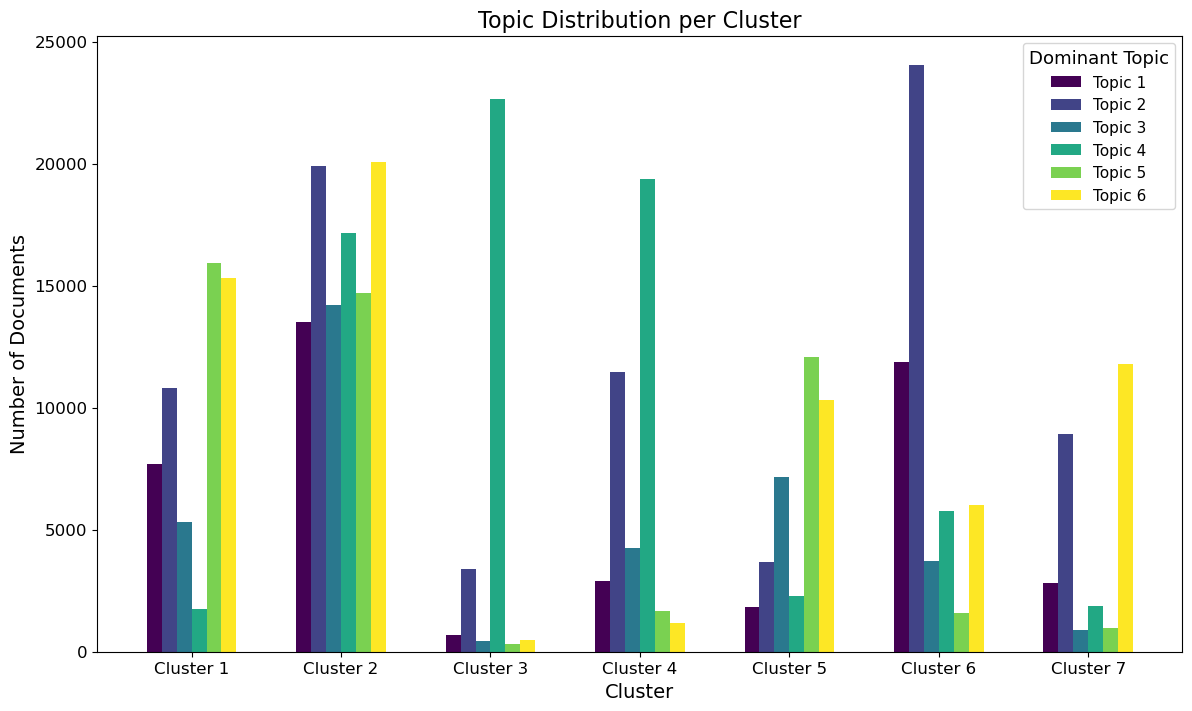

In [78]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

data = cluster_df

# DataFrame
df = pd.DataFrame(data)

# Vectorizer
tfidf_vectorizer = TfidfVectorizer(max_df=0.85, min_df=5, stop_words='english')

# used TF-IDF to 'text'
tfidf_matrix = tfidf_vectorizer.fit_transform(df['text'])

# LDA
lda = LatentDirichletAllocation(n_components=6, random_state=0)
lda.fit(tfidf_matrix)

# Dominant topic
doc_topic = lda.transform(tfidf_matrix)
dominant_topic = np.argmax(doc_topic, axis=1)
df['Dominant Topic'] = dominant_topic

# Create an empty DataFrame to store the results
topic_distribution = pd.DataFrame(0, index=np.arange(k), columns=['Topic '+str(i) for i in range(6)])

# Calculate the number of documents in each cluster for each topic
for cluster in range(k):
    for topic in range(6):
        # Count the number of documents in the current cluster that belong to the specified topic
        topic_distribution.loc[cluster, 'Topic '+str(topic)] = np.sum((labels == cluster) & (dominant_topic == topic))

print(topic_distribution)



n_clusters = topic_distribution.shape[0]  # clusters num
n_topics = topic_distribution.shape[1]  # topic num
cluster_labels = ['Cluster {}'.format(i+1) for i in range(n_clusters)]

# plot
fig, ax = plt.subplots(figsize=(14, 8))
bar_width = 0.1  
indices = np.arange(n_clusters) 
colors = plt.cm.viridis(np.linspace(0, 1, n_topics))

for i in range(n_topics):
    ax.bar(indices + i * bar_width, topic_distribution.iloc[:, i], width=bar_width, label='Topic {}'.format(i + 1), color=colors[i])

# label
ax.set_xlabel('Cluster', fontsize=14)
ax.set_ylabel('Number of Documents', fontsize=14)
ax.set_title('Topic Distribution per Cluster', fontsize=16)
ax.set_xticks(indices + bar_width * (n_topics - 1) / 2)
ax.set_xticklabels(cluster_labels)
ax.legend(title='Dominant Topic', title_fontsize='13', fontsize='11')

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.setp(ax.get_xticklabels(), rotation=0) 

plt.show()


